### To start, let's import necessary libraries and gather the information we need

In [154]:
import math, pandas as pd, numpy as np, matplotlib.pyplot as plt
%matplotlib inline

In [155]:
mDf = pd.read_csv('murder_per_100000_people.csv')
hDf = pd.read_csv('hapiscore_whr.csv')
fDf = pd.read_csv('food_supply_kilocalories_per_person_and_day.csv')
pDf = pd.read_csv('corruption_perception_index_cpi.csv')
files = [fDf, pDf, hDf, mDf]
cols = ["Country", "Food Supply (kCal/person/day)", "Non-Corruption Score", "Happiness Score", "Murders (by 1000 people)"]

### Select parts (year, countries) of each dataset, clean, then form a new set and save

In [156]:
# Variables
cntrs = []
allCntrs = []
fullRowInfo = []

# Clean data
for i in range(len(files)):
    files[i] = pd.Series(list(files[i]["2011"]), index = list(files[i]["country"])) # chose 2011 because it seems to have a good amount of data for each set
    files[i].dropna(inplace = True)

# Choose countries that will work for all data sets
for i in files:
    allCntrs.append(i.keys())
for i in allCntrs:
    for j in i:
        cntrs.append(j)

valids = dict.fromkeys(cntrs)
for i in dict.fromkeys(cntrs):
    if cntrs.count(i) < len(allCntrs):
        valids.pop(i)
valids = list(valids)

# Make new datasets with only those countries, create and save dataframe
for i in valids:
    add = [i]
    for j in files:
        add.append(j[i])
    fullRowInfo.append(add)
    
allData = pd.DataFrame(fullRowInfo, columns = cols)
allData.to_csv("healthAndSafety.csv")

### Individual data analysis

In [157]:
def oneVarInfo(data):
    data.sort()
    diffSquared = []
    outliers = []
    
    # Find variance
    mean = sum(data) / len(data)
    for i in data:
        diffSquared.append((i - mean) ** 2)
    pVar = sum(diffSquared) / len(diffSquared)
    sVar = sum(diffSquared) / (len(diffSquared) - 1)
    
    # Find quartiles and iqr
    term = (len(data) + 1)
    q1 = (data[int(term / 4) - 1] + data[math.ceil(term / 4) - 1]) / 2 # subtracting 1 because of computer indexing
    q2 = (data[int(term / 2) - 1] + data[math.ceil(term / 2) - 1]) / 2
    q3 = (data[int(3 * term / 4) - 1] + data[math.ceil(3 * term / 4) - 1]) / 2
    iqr = q3 - q1
    
    # Find outliers
    lowerFence = q1 - (1.5 * iqr)
    higherFence = q3 + (1.5 * iqr)
    for i in data:
        if (i < lowerFence or i > higherFence) and str(i) not in outliers:
            outliers.append(i)
    
    # Returns in order: mean, pop. variance, pop. standard dev, sam. variance, sam. standard deviation, quartiles, iqr, fences, outliers
    return mean, pVar, math.sqrt(pVar), sVar, math.sqrt(sVar), (q1, q2, q3), iqr, lowerFence, higherFence, outliers

In [158]:
oneVarVals = []

for i in files:
    info = oneVarInfo(i.tolist())
    oneVarVals.append([info[0], info[3], info[4], info[5], info[9]])

ttls = ["Mean", "Variance", "Standard Deviation", "Quartiles", "Outliers"] # calculated for SAMPLE
oneVarStats = pd.DataFrame(oneVarVals, columns = ttls, index = cols[1:])
oneVarStats

,Mean,Variance,Standard Deviation,Quartiles,Outliers
Food Supply (kCal/person/day),2835.459770,188748.631320,434.452105,"(2500.0, 2810.0, 3185.0)",[]
Non-Corruption Score,43.267045,387.076851,19.674269,"(28.5, 37.0, 56.5)",[]
Happiness Score,54.418571,126.544545,11.249202,"(45.85, 52.650000000000006, 62.45)",[]
Murders (by 1000 people),1.377745,1.653155,1.285751,"(0.568, 0.97, 1.51)","[3.93, 4.31, 4.41, 4.79, 4.98, 4.98]"


### Two-Variable Data Analysis

In [159]:
def pairsInfo(xVals, yVals):
    # Variables
    n = len(xVals)
    sumX = sum(xVals)
    sumY = sum(yVals)
    sumXSquared = 0
    sumYSquared = 0
    sumXY = 0
    corrCoeff = 0
    corrType = ["none", "weak", "moderate", "strong", "perfect"]
    corrSign = "positive"
    lstSqrsA = 0
    lstSqrsB = 0
    lstSqrsLn = ""
    
    # Set proper values for the sum values
    for i in range(n):
        sumXSquared += (xVals[i]) ** 2
        sumYSquared += (yVals[i]) ** 2
        sumXY += (xVals[i]) * yVals[i]
    
    # Proper values for coefficient and relation-type
    corrCoeff = ((n * sumXY) - (sumX) * (sumY))/(math.sqrt((n * sumXSquared) - (sumX) ** 2) * math.sqrt((n * sumYSquared) - (sumY) ** 2))
    cc = round(abs(corrCoeff), 2)
    
    if cc == 0:
        corrType = corrType[0]
    elif cc < (1 / 3) and cc > 0:
        corrType = corrType[1]
    elif cc < (2 / 3) and cc >= (1 / 3):
        corrType = corrType[2]
    elif cc < 1 and cc >= (2 / 3):
        corrType = corrType[3]
    else:
        corrType = corrType[4]
    
    if corrCoeff < 0:
        corrSign = "negative"
    elif corrCoeff == 0:
        corrSign = ""
    
    # Linear regression real values
    lstSqrsA = (n * (sumXY) - (sumX * sumY)) / ((n * sumXSquared) - (sumX) ** 2)
    lstSqrsB = (sumY / n) - (lstSqrsA * (sumX / n))
    lstSqrsLn = "y = %.5fx + %.5f" %(lstSqrsA, lstSqrsB)
    
    return corrCoeff, corrType, corrSign, lstSqrsA, lstSqrsB, lstSqrsLn

In [160]:
def drawGraph(ind, dep, dSet = allData):
    dSet.plot(kind = "scatter", x = ind, y = dep)
    fcRelInfo = pairsInfo(dSet[ind].tolist(), dSet[dep].tolist())
    fcRelInfo = list(fcRelInfo)  
    x = sorted(dSet[ind].tolist()) # largest value on the x-axis of data
    plt.plot([x[0], x[-1]], [(fcRelInfo[3] * x[0]) + fcRelInfo[4], (fcRelInfo[3] * x[-1]) + fcRelInfo[4]], label = fcRelInfo[5])
    plt.legend()
    plt.title(ind + " v.s " + dep)
    plt.show()
    return "correlation: " + str(fcRelInfo[:3])

### Graphed results

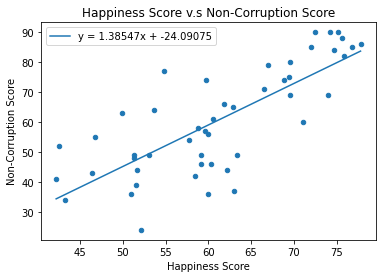

correlation: [0.769468378678456, 'strong', 'positive']


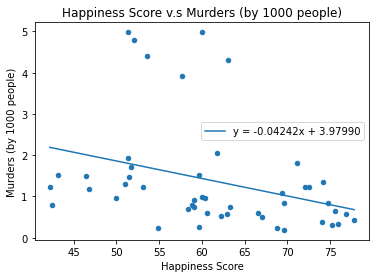

correlation: [-0.3241805420794089, 'weak', 'negative']


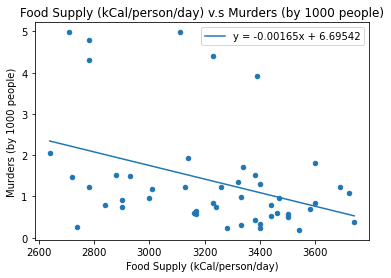

correlation: [-0.37670169784785795, 'moderate', 'negative']


array([[<AxesSubplot:title={'center':'Happiness Score'}>]], dtype=object)

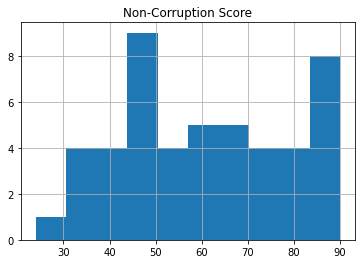

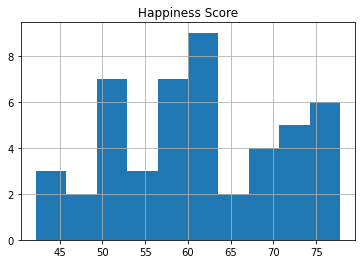

In [161]:
# recall cols = ["Country", "Food Supply (kCal/person/day)", "Non-Corruption Score", "Happiness Score", "Murders (by 1000 people)"]
# below each graph is printed its correlation coefficient, strength and direction
print(drawGraph(cols[3], cols[2]))
print(drawGraph(cols[3], cols[4]))
print(drawGraph(cols[1], cols[4]))
allData.hist(column = cols[2], bins = 10)
allData.hist(column = cols[3], bins = 10)

#### Check significance of outliers

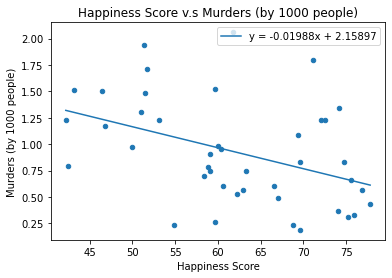

correlation: [-0.41646422443577436, 'moderate', 'negative']


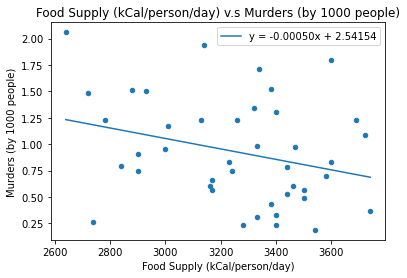

correlation: [-0.2907537525126506, 'weak', 'negative']


In [162]:
notList = ["Estonia", "Kyrgyz Republic", "Latvia", "Lithuania", "Moldova", "Thailand"]
outsDropped = allData.copy()
for i in outsDropped.index:
    if outsDropped.loc[i, "Country"] in notList:
        outsDropped.drop(i, inplace = True)

print(drawGraph(cols[3], cols[4], outsDropped))
print(drawGraph(cols[1], cols[4], outsDropped))